# Intro

In [ ]:
!pip install openai
!pip install datasets
!pip install pandas
!pip install matplotlib

### Dataset A Risposta Aperta

In [ ]:
from datasets import load_dataset
import pandas as pd
import random

MedQnA_dataset = load_dataset('keivalya/MedQuad-MedicalQnADataset')

# Access the first five examples from the 'train' split
MedQnA_dataset = MedQnA_dataset['train']

# Creazione di un DataFrame Pandas con le sole colonne 'question', 'options' e 'correct_answer'
MedQnA_pd = pd.DataFrame({
    'question': MedQnA_dataset['Question'],
    'answer': MedQnA_dataset['Answer'],
})

random.seed(42)

# Limita il dataset ai primi 10 elementi
MedQnA_pd = MedQnA_pd.sample(n=50, random_state=42).reset_index()

In [ ]:
# Visualizzazione del DataFrame
MedQnA_pd

,index,question,answer
0,3634,What are the treatments for High Blood Pressure ?,"Today, many different types of medicines are a..."
1,15104,What are the treatments for 21-hydroxylase def...,What is the goal for treating 21-hydroxylase-d...
2,4395,How to diagnose Fanconi Anemia ?,People who have Fanconi anemia (FA) are born w...
3,10274,How many people are affected by glutaric acide...,Glutaric acidemia type I occurs in approximate...
4,149,how is hps diagnosed and treated for Hantavirus ?,Diagnosing HPS\n \nDiagnosing HPS in an indiv...
5,1624,What are the symptoms of Microscopic Colitis: ...,The most common symptom of microscopic colitis...
6,7176,Is surfactant dysfunction inherited ?,Surfactant dysfunction can have different inhe...
7,7261,Is complement component 2 deficiency inherited ?,This condition is inherited in an autosomal re...
8,14711,What are the symptoms of Charcot-Marie-Tooth d...,What are the signs and symptoms of Charcot-Mar...
9,6728,What is (are) 3MC syndrome ?,3MC syndrome is a disorder characterized by un...


### Import delle liberie e delle chiavi

In [ ]:
import json
import openai

In [ ]:
# Set your OpenAI API key here
api_key = ''
openai.api_key = api_key

# Prompt engineerig improvement

In [ ]:
# Add Chain of Thoughts to the prompt
CoT = "Think step by step before answering"
# Add Self Consistency with CoT to the prompt
CoTSC = 'Think step by step before answering and give three answers: if a domain expert were to answer, if a supervisor were to answer, and your answer'
#Add Tagged Context Prompts
tagged_source= "Provide details and include sources in the answer."
#Add Self-Correct
self_correct = "Choose the most likely answer from the list. Then carefully double-check your answer. Think about whether this is the right answer, would others agree with it? Improve your answer as needed."
#Add Context and Reasoning
Context_Injection = """ As a skilled medical domain expert, your role is to analyze multiple-choice questions, choose the correct
answer from the given options, and provide a clear explanation for your choice. Additionally, you should
explain why the other options are not correct. If none of the provided options is correct, choose ’none
of the above’. Your explanation should be precise and free of incomplete or incorrect biomedical or
clinical details. """

## Inizializzazione liste di risposte

In [ ]:
# Lista per salvare le risposte delle prime completions per il dataset QnA
initial_responses_QnA = []
# Lista per salvare le risposte delle completions con CoT per il dataset QnA
cot_responses_QnA = []
# Lista per salvare le risposte delle completions con CoTSC per il dataset QnA
cotsc_responses_QnA = []
# Lista per salvare le risposte delle completions con Tagged Context per il dataset QnA
tagged_source_responses_QnA = []
# Lista per salvare le risposte delle completions con Self Correct per il dataset QnA
self_correct_responses_QnA = []
# Lista per salvare le risposte delle completions con Context Injection per il dataset QnA
context_injection_responses_QnA = []

## Generazione delle risposte per il Dataset A Risposta Aperta

In [ ]:
def generate_and_save_responses(prompts, responses_list):
    for i, prompt in enumerate(prompts, start=1):
        print(f"Question {i}: {prompt}")

        completion = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                },
            ],
        )

        responses_list.append(completion.choices[0].message.content)

In [ ]:
# Genera i prompts per le domande senza modifiche
original_prompts = [f"{question['question']}" for _, question in MedQnA_pd.iterrows()]
# Genera i prompts con CoT per le domande
cot_prompts = [f"{prompt}\n{CoT}" for prompt in original_prompts]
# Genera i prompts con CoTSC per le domande
cotsc_prompts = [f"{prompt}\n{CoTSC}" for prompt in original_prompts]
# Genera i prompts con Tagged Context per le domande
tagged_context_prompts = [f"{prompt}\n{tagged_source}" for prompt in original_prompts]
# Genera i prompts con Self Correct per le domande
self_correct_prompts = [f"{prompt}\n{self_correct}" for prompt in original_prompts]
# Genera i prompts con Context Injection per le domande
context_injection_prompts = [f"{prompt}\n{Context_Injection}" for prompt in original_prompts]

In [ ]:
# Genera e salva le prime completions per i prompts originali
print("Original Prompt:\n")
generate_and_save_responses(original_prompts, initial_responses_QnA)
# Genera e salva le completions con CoT
print("CoT Prompt:\n")
generate_and_save_responses(cot_prompts, cot_responses_QnA)
# Genera e salva le completions con CoTSC
print("CoTSC Prompt:\n")
generate_and_save_responses(cotsc_prompts, cotsc_responses_QnA)
# Genera e salva le completions con Tagged Context
print("Tagged Source Prompt:\n")
generate_and_save_responses(tagged_context_prompts, tagged_source_responses_QnA)
# Genera e salva le completions con Self Correct
print("Self Correct Prompt:\n")
generate_and_save_responses(self_correct_prompts, self_correct_responses_QnA)
# Genera e salva le completions con Context Injection
print("Context Injection Prompt:\n")
generate_and_save_responses(context_injection_prompts, context_injection_responses_QnA)

Original Prompt:

Question 1: What are the treatments for High Blood Pressure ?
Question 2: What are the treatments for 21-hydroxylase deficiency ?
Question 3: How to diagnose Fanconi Anemia ?
Question 4: How many people are affected by glutaric acidemia type I ?
Question 5: how is hps diagnosed and treated for Hantavirus ?
Question 6: What are the symptoms of Microscopic Colitis: Collagenous Colitis and Lymphocytic Colitis ?
Question 7: Is surfactant dysfunction inherited ?
Question 8: Is complement component 2 deficiency inherited ?
Question 9: What are the symptoms of Charcot-Marie-Tooth disease type 2O ?
Question 10: What is (are) 3MC syndrome ?
Question 11: what is yersiniosis for Yersinia ?
Question 12: What are the treatments for Mainzer-Saldino syndrome ?
Question 13: Is diastrophic dysplasia inherited ?
Question 14: What are the treatments for Cryptogenic organizing pneumonia ?
Question 15: What is (are) tuberous sclerosis complex ?
Question 16: What is (are) medium-chain acyl

In [ ]:
def print_responses(responses, prompt_type):
    print(f"Risposte per il {prompt_type}:\n")
    for i, response in enumerate(responses, start=1):
        print(f"Risposta {i}:")
        print(response)
        print()

In [ ]:
# Stampare le risposte per i diversi tipi di prompt
print_responses(initial_responses_QnA, "prompt originale")
print_responses(cot_responses_QnA, "prompt CoT")
print_responses(cotsc_responses_QnA, "prompt CoTSC")
print_responses(tagged_source_responses_QnA, "prompt Tagged Context")
print_responses(self_correct_responses_QnA, "prompt Self Correct")
print_responses(context_injection_responses_QnA, "prompt Context Injection")

Risposte per il prompt originale:

Risposta 1:
The treatments for high blood pressure, also known as hypertension, typically include lifestyle changes and medication. Some common treatments include:

1. Lifestyle modifications: These include maintaining a healthy weight, consuming a balanced diet low in sodium (called the DASH diet), reducing alcohol consumption, quitting smoking, and engaging in regular physical activity.

2. Medications: Several classes of medications are used to treat hypertension, including:

   - Diuretics: These medications increase urination, reducing fluid volume and blood pressure.
   - Beta-blockers: These drugs reduce heart rate and the force of heart contractions, lowering blood pressure.
   - ACE inhibitors (Angiotensin-Converting Enzyme inhibitors): These medications relax blood vessels, making it easier for blood to flow.
   - Angiotensin II receptor blockers (ARBs): Similar to ACE inhibitors, ARBs relax and widen blood vessels.
   - Calcium channel bloc

# Evaluation

## Definizione delle funzioni per valutare la bonta delle risposte

### Coherence - To evaluate on Dataset QA

Coerenza:
La coerenza è una misura della similarità tra la risposta generata dal modello e la risposta corretta fornita nel dataset (ground truth). Questa metrica valuta quanto la risposta fornita dal modello sia simile alla risposta corretta.

Calcolo della Coerenza:

Utilizza la similarità coseno tra i vettori di embedding delle risposte generate e delle risposte corrette.
Gli embedding rappresentano le rappresentazioni vettoriali delle risposte, catturando il significato semantico e contestuale delle parole o frasi.
La similarità coseno è una misura di quanto due vettori siano diretti nella stessa direzione nello spazio vettoriale.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_coherence(generate_answer, ground_truth):
    vectorizer = CountVectorizer()
    matrix = vectorizer.fit_transform([generate_answer, ground_truth])
    similarity_matrix = cosine_similarity(matrix)
    coherence_score = similarity_matrix[0, 1]
    return coherence_score

def calculate_coherence_with_dataframe_responses(responses, ground_truth_df, response_type):
    coherence_scores = []

    print(f"Tipo di prompt utilizzato: {response_type}")
    for i, response_text in enumerate(responses):
        ground_truth = ground_truth_df.iloc[i]['answer']
        coherence_score = calculate_coherence(response_text, ground_truth)
        coherence_scores.append(coherence_score)

        print(f"Risposta {i+1} -> Coherence Score : {coherence_score}", end=";\n")

    average_coherence_score = sum(coherence_scores) / len(coherence_scores)
    print(f"Coherence score medio : {average_coherence_score}\n")

    print("\n")
    return coherence_scores


Risposta 16:
Medium-chain acyl-CoA dehydrogenase deficiency (MCADD) is a genetic disorder that affects the body's ability to break down medium-chain fatty acids for energy. The deficiency of the enzyme medium-chain acyl-CoA dehydrogenase leads to an inability to convert these fatty acids into a usable form, resulting in a build-up of harmful substances in the body. This disorder mainly affects the liver, heart, and muscles and can manifest with symptoms such as lethargy, hypoglycemia, vomiting, and seizures. Early detection and management of MCADD through dietary modifications are crucial to prevent life-threatening complications.

Risposta 17:
Children with certain genetic syndromes, such as Down syndrome or Fanconi anemia, are at higher risk for developing Childhood Acute Myeloid Leukemia and other myeloid malignancies. Gene mutations, exposure to certain chemicals or radiation, and a family history of these types of cancers may also increase the risk.

Risposta 18:
Floods are natur

In [ ]:
# Dizionario per associare i vari tipi di risposte ai loro risultati
responses_to_evaluate = {
    "Initial": initial_responses_QnA,
    "CoT": cot_responses_QnA,
    "CoTSC": cotsc_responses_QnA,
    "Tagged Source": tagged_source_responses_QnA,
    "Self Correct": self_correct_responses_QnA,
    "Context Injection": context_injection_responses_QnA,
}

# Dizionario per i punteggi di coerenza di ogni tipo di risposta
coherence_scores = {
    "Initial": [],
    "CoT": [],
    "CoTSC": [],
    "Tagged Source": [],
    "Self Correct": [],
    "Context Injection": [],
}

In [ ]:
# Iterazione attraverso il dizionario di risposte
for response_type, responses in responses_to_evaluate.items():
    # Calcola i punteggi di coerenza per il tipo di risposta corrente
    scores = calculate_coherence_with_dataframe_responses(responses, MedQnA_pd, response_type)
    coherence_scores[response_type] = scores

Tipo di prompt utilizzato: Initial
Risposta 1 -> Coherence Score : 0.5873291104037237;
Risposta 2 -> Coherence Score : 0.6020370217225165;
Risposta 3 -> Coherence Score : 0.6588628762956594;
Risposta 4 -> Coherence Score : 0.5299213535857301;
Risposta 5 -> Coherence Score : 0.652236265591608;
Risposta 6 -> Coherence Score : 0.6404652172785488;
Risposta 7 -> Coherence Score : 0.36874092283506865;
Risposta 8 -> Coherence Score : 0.5917378937102098;
Risposta 9 -> Coherence Score : 0.5689020833408613;
Risposta 10 -> Coherence Score : 0.6404702767287863;
Risposta 11 -> Coherence Score : 0.6225200351509109;
Risposta 12 -> Coherence Score : 0.45928194777290887;
Risposta 13 -> Coherence Score : 0.5124199406384242;
Risposta 14 -> Coherence Score : 0.4945639225128815;
Risposta 15 -> Coherence Score : 0.7746167154797405;
Risposta 16 -> Coherence Score : 0.7203180330800063;
Risposta 17 -> Coherence Score : 0.5486492841619469;
Risposta 18 -> Coherence Score : 0.42332033997268903;
Risposta 19 -> Coh

**Plotting**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

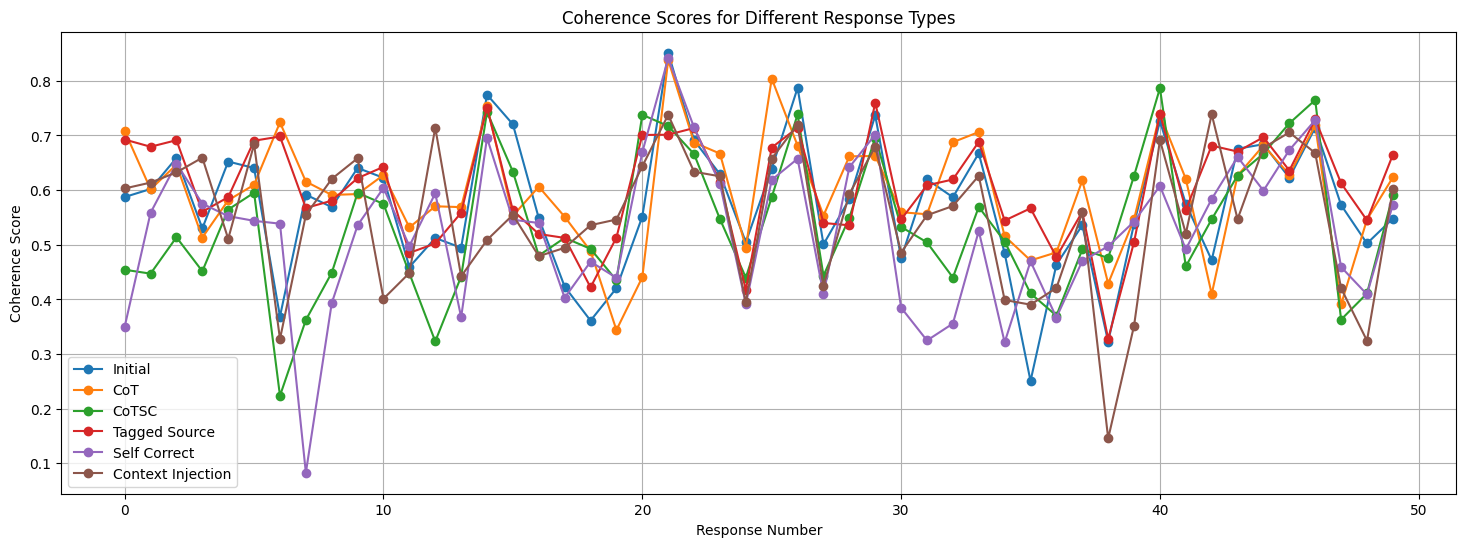

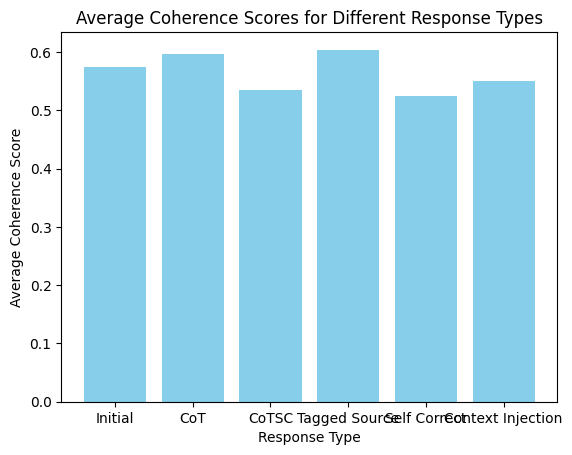

In [ ]:
# Plot individual coherence scores
plt.figure(figsize = (18,6))
for response_type, scores in coherence_scores.items():
    plt.plot(np.arange(len(scores)), scores, marker='o', linestyle='-', label=response_type)
plt.title("Coherence Scores for Different Response Types")
plt.xlabel("Response Number")
plt.ylabel("Coherence Score")
plt.grid(True)
plt.legend()
plt.show()

# Plot average coherence scores
average_coherence_scores = {
    response_type: sum(scores) / len(scores) if len(scores) > 0 else 0
    for response_type, scores in coherence_scores.items()
}
plt.figure(figsize = (16,8))
plt.bar(average_coherence_scores.keys(), average_coherence_scores.values(), color='skyblue')
plt.title("Average Coherence Scores for Different Response Types")
plt.xlabel("Response Type")
plt.ylabel("Average Coherence Score")
plt.show()

### Completeness - To evaluate on Dataset QA

Completezza:
La completezza valuta quanto la risposta generata copra o includa le informazioni presenti nella risposta corretta. Essa mira a valutare quanto della risposta corretta è stato catturato dalla risposta generata.

Calcolo della Completezza:

Calcola il rapporto tra il numero di parole comuni tra la risposta generata e la risposta corretta e il numero totale di parole nella risposta corretta.
Misura la percentuale di informazioni presenti nella risposta corretta che è stata inclusa nella risposta generata.

In [ ]:
def calculate_completeness(generate_answer, ground_truth):
    generate_answer = generate_answer.lower()
    ground_truth = ground_truth.lower()

    generate_words = set(generate_answer.split())
    ground_truth_words = set(ground_truth.split())

    common_words = generate_words.intersection(ground_truth_words)
    completeness_score = len(common_words) / len(ground_truth_words)

    return completeness_score

def calculate_completeness_with_dataframe_responses(responses, ground_truth_df, response_type):
    completeness_scores = []

    print(f"Tipo di prompt utilizzato: {response_type}")
    for i, response_text in enumerate(responses):
        ground_truth = ground_truth_df.iloc[i]['answer']
        completeness_score = calculate_completeness(response_text, ground_truth)
        completeness_scores.append(completeness_score)

        print(f"Risposta {i+1} --> Completeness Score : {completeness_score}", end=";\n")

    average_completeness_score = sum(completeness_scores) / len(completeness_scores)
    print(f"Completeness score medio : {average_completeness_score}\n")

    print("\n")
    return completeness_scores

In [ ]:
# Dizionario per associare i vari tipi di risposte ai loro risultati
responses_to_evaluate_completeness = {
    "Initial": initial_responses_QnA,
    "CoT": cot_responses_QnA,
    "CoTSC": cotsc_responses_QnA,
    "Tagged Source": tagged_source_responses_QnA,
    "Self Correct": self_correct_responses_QnA,
    "Context Injection": context_injection_responses_QnA,
}

# Dizionario per i punteggi di completezza di ogni tipo di risposta
completeness_scores = {
    "Initial": [],
    "CoT": [],
    "CoTSC": [],
    "Tagged Source": [],
    "Self Correct": [],
    "Context Injection": [],
}

In [ ]:
# Iterazione attraverso il dizionario di risposte
for response_type, responses in responses_to_evaluate_completeness.items():
    # Calcola i punteggi di completezza per il tipo di risposta corrente
    scores = calculate_completeness_with_dataframe_responses(responses, MedQnA_pd, response_type)
    completeness_scores[response_type] = scores

Tipo di prompt utilizzato: Initial
Risposta 1 --> Completeness Score : 0.2777777777777778;
Risposta 2 --> Completeness Score : 0.24347826086956523;
Risposta 3 --> Completeness Score : 0.17942583732057416;
Risposta 4 --> Completeness Score : 0.42424242424242425;
Risposta 5 --> Completeness Score : 0.312;
Risposta 6 --> Completeness Score : 0.39080459770114945;
Risposta 7 --> Completeness Score : 0.19047619047619047;
Risposta 8 --> Completeness Score : 0.39473684210526316;
Risposta 9 --> Completeness Score : 0.27972027972027974;
Risposta 10 --> Completeness Score : 0.25210084033613445;
Risposta 11 --> Completeness Score : 0.36363636363636365;
Risposta 12 --> Completeness Score : 0.4090909090909091;
Risposta 13 --> Completeness Score : 0.4473684210526316;
Risposta 14 --> Completeness Score : 0.4166666666666667;
Risposta 15 --> Completeness Score : 0.43333333333333335;
Risposta 16 --> Completeness Score : 0.48598130841121495;
Risposta 17 --> Completeness Score : 0.3617021276595745;
Rispost

**Plotting**

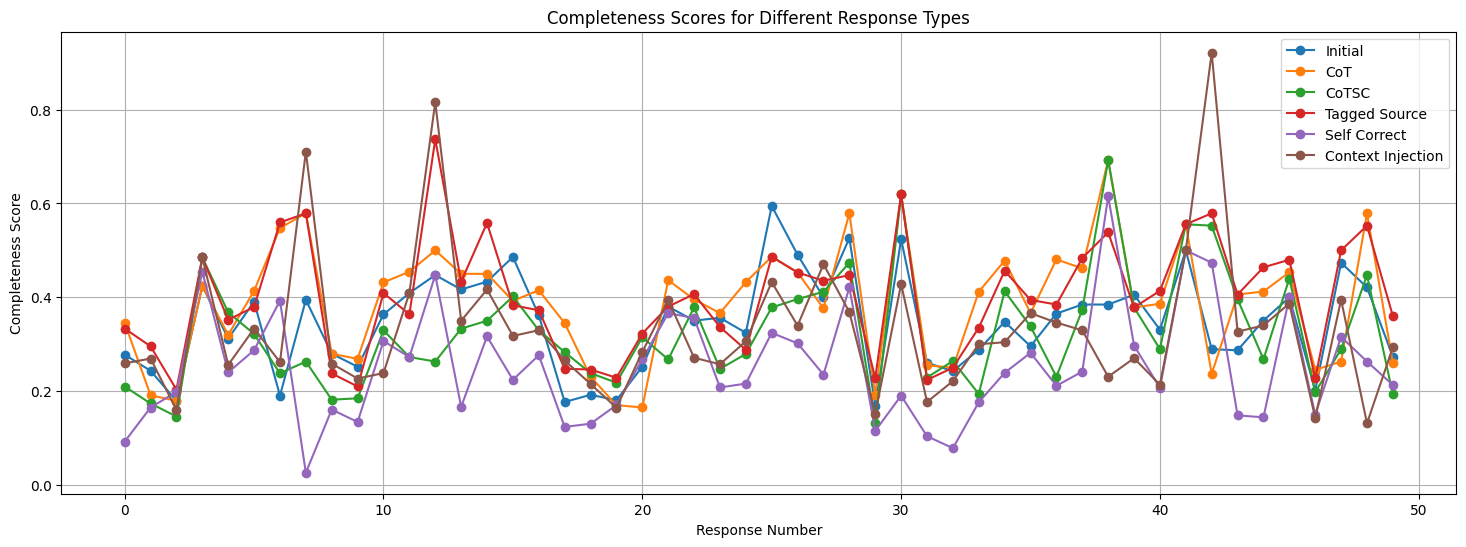

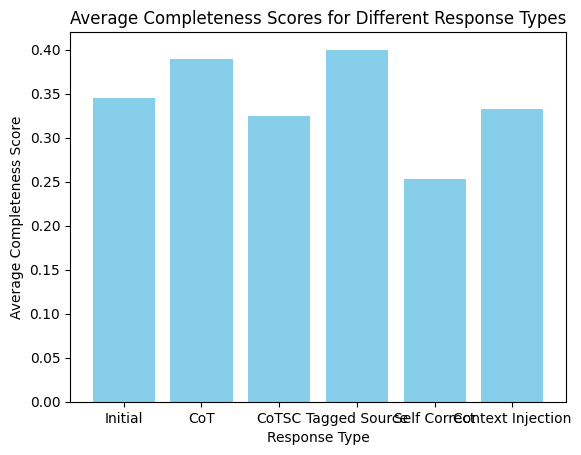

In [ ]:
# Plot individual completeness scores
plt.figure(figsize = (18,6))
for response_type, scores in completeness_scores.items():
    plt.plot(np.arange(len(scores)), scores, marker='o', linestyle='-', label=response_type)

plt.title("Completeness Scores for Different Response Types")
plt.xlabel("Response Number")
plt.ylabel("Completeness Score")
plt.grid(True)
plt.legend()
plt.show()

# Plot average completeness scores
average_completeness_scores = {
    response_type: sum(scores) / len(scores) if len(scores) > 0 else 0
    for response_type, scores in completeness_scores.items()
}
plt.figure(figsize = (16,8))
plt.bar(average_completeness_scores.keys(), average_completeness_scores.values(), color='skyblue')
plt.title("Average Completeness Scores for Different Response Types")
plt.xlabel("Response Type")
plt.ylabel("Average Completeness Score")
plt.show()

### Relevance - To evaluate on Dataset QA

Rilevanza:
La rilevanza valuta quanto la risposta generata sia rilevante rispetto alla domanda originale. Indica se la risposta fornita dal modello è adeguata e pertinente alla domanda posta.

Calcolo della Rilevanza:

Utilizza il modello preaddestrato BERT per calcolare la similarità tra i vettori di embedding delle risposte e delle domande.
La similarità coseno tra i vettori di embedding delle risposte e delle domande rappresenta quanto le risposte generative siano semanticamente vicine alle domande originali.

In [ ]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 4.1 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer, util

# Load Sentence-BERT model
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

# Caricamento del tokenizer e del modello preaddestrato BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
def calculate_relevance_sbert(question, response):
    # Calculate sentence embeddings
    question_embedding = sbert_model.encode(question, convert_to_tensor=True)
    response_embedding = sbert_model.encode(response, convert_to_tensor=True)

    # Calculate cosine similarity
    similarity_score = util.pytorch_cos_sim(question_embedding, response_embedding).item()

    return similarity_score

def calculate_relevance_with_dataframe_responses_sbert(questions, responses, response_type):
    relevance_scores = []

    print(f"Tipo di prompt utilizzato: {response_type}")
    for i, response_text in enumerate(responses):
        # Ensure questions and responses have the same length
        if i < len(questions):
            try:
                relevance_score = calculate_relevance_sbert(questions[i], response_text)
                relevance_scores.append(relevance_score)

                print(f"Risposta {i+1} --> Relevance Score : {relevance_score}", end=";\n")
            except Exception as e:
                print(f"Error processing response {i+1}: {str(e)}")
    average_relevance_scores = sum(relevance_scores) / len(relevance_scores) if len(relevance_scores) > 0 else 0
    print(f"Relevance score medio : {average_relevance_scores}\n")

    print("\n")
    return relevance_scores

In [ ]:
# Dizionario per associare i vari tipi di risposte ai loro risultati
responses_to_evaluate_relevance_bert = {
    "Initial": initial_responses_QnA,
    "CoT": cot_responses_QnA,
    "CoTSC": cotsc_responses_QnA,
    "Tagged Source": tagged_source_responses_QnA,
    "Self Correct": self_correct_responses_QnA,
    "Context Injection": context_injection_responses_QnA,
}

# Calcola la rilevanza tra le risposte generate e le domande utilizzando il modello BERT
questions_list = MedQnA_pd['question'].tolist()  # Lista delle domande

In [ ]:
# Iterazione attraverso il dizionario di risposte
for response_type, responses in responses_to_evaluate_relevance_bert.items():
    # Calcola i punteggi di rilevanza per il tipo di risposta corrente
    scores = calculate_relevance_with_dataframe_responses_sbert(questions_list, responses, response_type)

**Plotting**

In [ ]:
def plot_multiple_relevance_scores(relevance_scores_dict, questions_list):
    plt.figure(figsize = (18,6))
    for response_type, scores in relevance_scores_dict.items():
        plt.plot(np.arange(len(scores)), scores, marker='o', linestyle='-', label=response_type)

    plt.title('Relevance Scores for Different Response Types')
    plt.xlabel('Question-Response Pair')
    plt.ylabel('Relevance Score')
    plt.legend()
    plt.grid(True)
    plt.show()

# Dictionary to store relevance scores for each response type
relevance_scores_dict = {}

# Iteration through the dictionary of responses
for response_type, responses in responses_to_evaluate_relevance_sbert.items():
    # Calculate relevance scores for the current response type
    scores = calculate_relevance_with_dataframe_responses_sbert(questions_list, responses, response_type)
    relevance_scores_dict[response_type] = scores

# Plot the relevance scores for different response types
plot_multiple_relevance_scores(relevance_scores_dict, questions_list)


In [ ]:
def plot_average_relevance_scores(relevance_scores_dict):
    # Calculate the average relevance score for each response type
    average_scores = {response_type: np.mean(scores) for response_type, scores in relevance_scores_dict.items()}

    # Plot the bar graph
    plt.figure(figsize = (16,8))
    plt.bar(average_scores.keys(), average_scores.values(), color='skyblue')
    plt.title('Average Relevance Scores for Different Response Types')
    plt.xlabel('Response Type')
    plt.ylabel('Average Relevance Score')
    plt.ylim(0, 1)  # Set y-axis limit between 0 and 1
    plt.show()

# Dictionary to store relevance scores for each response type
relevance_scores_dict = {}

# Iteration through the dictionary of responses
for response_type, responses in responses_to_evaluate_relevance_sbert.items():
    # Calculate relevance scores for the current response type
    scores = calculate_relevance_with_dataframe_responses_sbert(questions_list, responses, response_type)
    relevance_scores_dict[response_type] = scores

# Plot the average relevance scores for different response types
plot_average_relevance_scores(relevance_scores_dict)